In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation
import matplotlib.gridspec as gridspec
from datetime import timedelta

import seaborn as sns
from pprint import pprint

from skimage import feature

from SentinelHubUtils import get_eopatch, delete_frame_eopatch, band_names


In [2]:
df = pd.read_csv('./data/01_removed_outliers/River_Arno.csv', sep=',', header=0, index_col=0)
df['Date'] = pd.to_datetime(df['Date']).dt.date
df = df.set_index('Date', verify_integrity=True)

In [3]:
river_Arno_dir_1 = './data/03_EO_River_Arno_1'

time_interval = ('2015-01-01', '2018-01-01')
geoPointBotLeft=(43.77050661961278, 11.410133120289633)
geoPointTopRight=(43.77301820761248, 11.439324869134165)

eopatch = get_eopatch(river_Arno_dir_1, (geoPointBotLeft, geoPointTopRight), time_interval)
eopatch

eopatch data was loaded from local directory


EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(18, 35, 234, 7), dtype=float32)
    NDVI: numpy.ndarray(shape=(18, 35, 234, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(18, 35, 234, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(18, 35, 234, 1), dtype=uint8)
    CLP: numpy.ndarray(shape=(18, 35, 234, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(18, 35, 234, 1), dtype=bool)
    VALID_DATA: numpy.ndarray(shape=(18, 35, 234, 1), dtype=bool)
  }
  scalar: {
    COVERAGE: numpy.ndarray(shape=(18, 1), dtype=float64)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.1
    service_type: 'processing'
    size_x: 234
    size_y: 35
    time_difference: datetime.timedelta(days=1)
    time_interval: ('2015-01-01T00:00:00', '2018-01-01T23:59:59')
  }
  bbox: BBox(((11.410133120289633, 43.77050661961278), (11.439324869134165, 43.77301820761248)), crs=CRS('4326

In [4]:
from WaterMaskUtils import get_water_mask, visualise_water_mask

(water_mask, water_edges, water_area) = get_water_mask(eopatch)

water_mask

# print(water_mask)


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

NameError: name 'gaussian_filter' is not defined

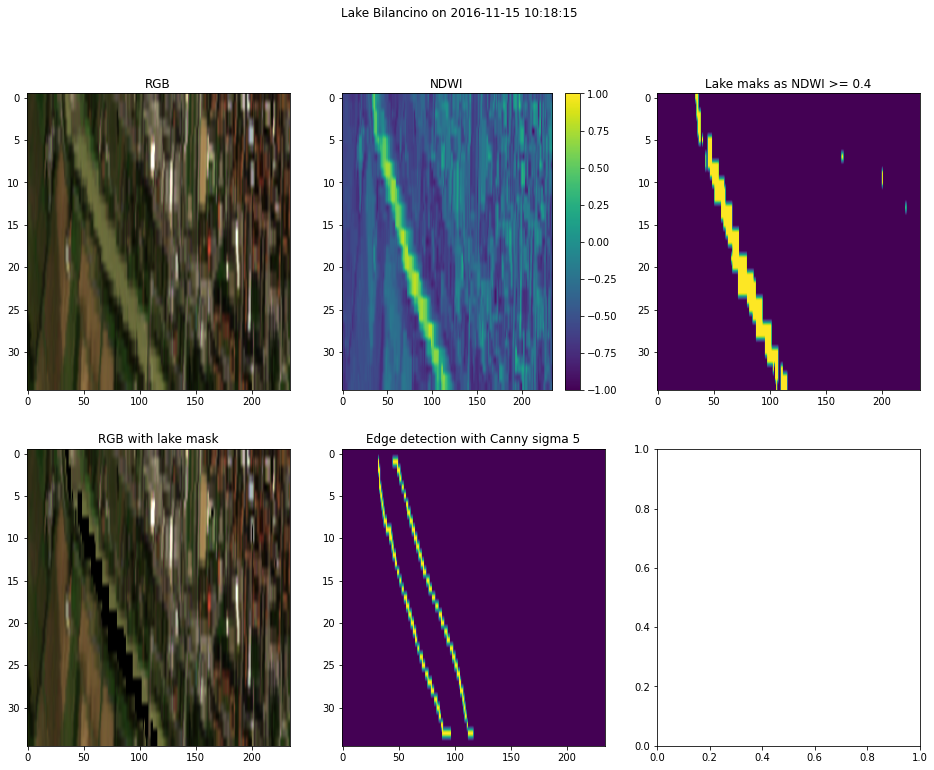

In [5]:
fig, ax = plt.subplots(2, 3, figsize=(16, 12))

fig.suptitle('Lake Bilancino on {}'.format(eopatch.timestamp[0]))

rgb = np.clip(eopatch.data['BANDS'][0][..., [band_names.index('B04'),band_names.index('B03'),band_names.index('B02')]] * 3, a_min=0, a_max=1)
ax[0][0].set_title('RGB')
ax[0][0].imshow(rgb, vmin=0, vmax=1, aspect='auto')

pos = ax[0][1].imshow(eopatch.data['NDWI'][0].squeeze(), aspect='auto', vmin=-1, vmax=1)
ax[0][1].set_title('NDWI')
fig.colorbar(pos, ax=ax[0][1])

lake_mask_treshold = 0.4
lake_mask = eopatch.data['NDWI'].squeeze()
lake_mask = lake_mask[:, :, :] >= lake_mask_treshold
lake_mask = np.logical_or.reduce(lake_mask)
ax[0][2].set_title('Lake maks as NDWI >= {}'.format(lake_mask_treshold))
ax[0][2].imshow(lake_mask, aspect='auto')

rgb2 = np.copy(rgb)
rgb2[lake_mask] = 0
ax[1][0].set_title('RGB with lake mask')
ax[1][0].imshow(rgb2, aspect='auto')

canny_sigma = 5
lake_edges = feature.canny(lake_mask, sigma=canny_sigma)
ax[1][1].set_title('Edge detection with Canny sigma {}'.format(canny_sigma))
ax[1][1].imshow(lake_edges, aspect='auto')

gaussian_filter_sigma = 1
lake_edges_wide = ~gaussian_filter(~lake_edges, sigma=gaussian_filter_sigma)

# lake_edges_wide = np.logical_and(~lake_mask, lake_edges_wide) # completly lake water out of mask

ax[1][2].set_title('Expanded shores mask to get area of interest')
ax[1][2].imshow(lake_edges_wide, aspect='auto')

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

rgb3 = np.copy(rgb)

lake_edges_wide_borders = feature.canny(lake_edges_wide, sigma=canny_sigma)
rgb3[lake_edges_wide_borders] = (1, 0, 0)
ax[0].imshow(rgb3, aspect='auto')
rgb3[lake_edges_wide] = (1, 0, 0)
ax[0].imshow(rgb3, aspect='auto', alpha=0.1)
ax[0].set_title('AoI over RGB')

NDWI_AoI = np.copy(eopatch.data['NDWI'][0].squeeze())
NDWI_AoI[~lake_edges_wide] = float('nan')

ax[1].set_title('AoI over NDWI')
ax[1].imshow(NDWI_AoI, aspect='auto', vmin=-1, vmax=1)